# Plot precip to contextualize drought metrics
We have been studying SPEI in context with percent glaciation and with historical aridity index.  We know from Finn's work that glacier models modify the incoming precip over glaciers, sometimes by a lot.  Is this at play in the basins where we see differences among the models' drought indices?

18 Jun 2024 | EHU
- 19 Jun 24: Added full set of 11 GCMs that Sloan pulled.  Updating model names accordingly.
- 25 Jul 24: Correct the units of the aggregated precip.  Current version is m3/mo.  Get to mm/day by (1) dividing by basin area in m2 and number of days in the associated month and (2) multiply by 1000 (m-->mm)
- 7 Aug 24: Correct read-in -- `P_by_basin` was reading in order of basins_all instead of basin_name_list. Updating this to reflect correct order makes these plots align with what Sloan has previously shown.

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
import gSPEI as gSPEI

In [2]:
default_colors = cm.get_cmap('plasma')

## Preliminary step: plot GCM precip directly
We have been showing a plot from Sloan that compares CMIP6 model dispersion in total basin precip over the Rhone.  What is the spread in our selected set of models?

In [3]:
## Define the filepath streamed from Google Drive
fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/GCM-PET_Precip/'


## Settings in filenames -- slightly different model names and scenarios
modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']
# scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
scenarios = ['Ssp4p5', 'Ssp8p5'] # climate scenarios included for 11 GCM set


yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [4]:
## Basins in the order they are written
basins_all = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202', 'TITICACA':'3912', 'SANTA':'3425', 
            'OCONA':'3418', 'MAJES':'3416', 'MAGDALENA':'3227', 'AMAZON':'3203', 'YELCHO':'3429', 
            'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 'PASCUA':'3420', 
            'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 'BIOBIO':'3405', 'BAKER':'3404',
            'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 'NEGRO':'3232', 'COLORADO':'3212', 
            'CHICO':'3209', 'TORNEALVEN':'6255', 'THJORSA':'6254', 'OLFUSA':'6237', 'LULEALVEN':'6227', 
            'KUBAN':'6223', 'KALIXALVEN':'6219', 'GLOMAA':'6213', 'DRAMSELVA':'6209', 'SVARTA':'6110', 
            'LAGARFLJOT':'6104', 'JOKULSA A FJOLLUM':'6101', 'CLUTHA':'5406', 'YUKON':'4435', 'TAKU':'4431', 
             'SUSITNA':'4430','STIKINE':'4428', 'SKEENA':'4427','SKAGIT':'4426','NUSHAGAK':'4418','NASS':'4416',
            'KUSKOKWIM':'4414','FRASER':'4410', 'COPPER':'4408', 'COLUMBIA':'4406', 'ALSEK':'4401', 'NELSON':'4125', 
              'MACKENZIE':'4123','COLVILLE':'4110', 'YSYK-KOL':'2919', 'UVS NUUR':'2918', 'TARIM HE':'2914', 
              'TALAS':'2913', 'LAKE BALKHASH':'2910','HAR US NUUR':'2909', 'CHUY':'2905', 'ARAL SEA':'2902', 
              'YELLOW RIVER':'2434', 'MEKONG':'2421', 'KAMCHATKA':'2413', 'SALWEEN':'2319', 'IRRAWADDY':'2310', 
              'INDUS':'2309', 'GANGES':'2306','BRAHMAPUTRA':'2302', 'OB':'2108', 'INDIGIRKA':'2103','YANGTZE' : '2433'}

In [5]:
#Loading in total Basin area data -- following Finn percent glaciation code
from scipy.io import loadmat
import pandas as pd
path_to_area = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/BasinArea.mat' ## need access!
BasinAreas = loadmat(path_to_area)
#Creating indexed df
basin_areas = BasinAreas['BasinArea']
basin_names = BasinAreas['BasinNam']
basin_name_list = [name[1][0] for name in basin_names]

TotalBasinAreas = pd.DataFrame({'Basin Area': basin_areas.squeeze()}, index=basin_name_list)
TotalBasinAreas = TotalBasinAreas.rename(index={'ISSYK-KUL': 'YSYK-KOL', 'LAGARFLIOT' : 'LAGARFLJOT'}).sort_index() #Same Basins

In [6]:
TotalBasinAreas

,Basin Area
AISEN,12294.4
ALSEK,28068.3
AMAZON,5965893.5
ARAL SEA,1372516.9
AZOPARDO,3541.6
...,...
YANGTZE,1748118.3
YELCHO,11389.2
YELLOW RIVER,962986.0
YSYK-KOL,21918.0


In [7]:
P_by_model = {m: {} for m in modelnames}
for m in modelnames:
    for s in scenarios:
        example_p = fpath+'{}_PREC_{}.txt'.format(m,s)
        P_by_model[m][s] = np.loadtxt(example_p)

In [8]:
# P_by_basin = {b: {} for b in basins_all} # precipitation by basin
P_by_basin = {b: {} for b in basin_name_list} # precipitation by basin, ordered per Sloan


for i, b in enumerate(basin_name_list):
    P_by_basin[b] = {s: {} for s in scenarios}
    for s in scenarios:
        tempdict_p = {}
        for m in modelnames:
            tempdict_p[m] = P_by_model[m][s][i]
        P_by_basin[b][s] = pd.DataFrame.from_dict(tempdict_p)

In [9]:
P_by_basin['RHONE']

{'Ssp4p5':        BCC-CSM2-MR  MPI-ESM1-2-HR    MRI-ESM2-0   CESM2-WACCM    NorESM2-MM  \
 0     5.140710e+09   5.169292e+09  1.104633e+10  1.809085e+10  1.561826e+10   
 1     1.184142e+10   7.333356e+09  8.700738e+09  5.580222e+09  3.986841e+09   
 2     9.944785e+09   3.180495e+09  7.895201e+09  1.539994e+10  1.193882e+10   
 3     4.659055e+09   1.400418e+10  8.753346e+09  1.128760e+10  1.219127e+10   
 4     1.254314e+10   5.293942e+09  1.430688e+10  1.447757e+10  9.521260e+09   
 ...            ...            ...           ...           ...           ...   
 2407  2.389441e+09   2.995575e+09  5.086340e+09  2.194873e+09  1.928569e+09   
 2408  3.776416e+09   3.542379e+09  9.108811e+09  2.269388e+09  2.544811e+09   
 2409  1.213660e+10   5.857224e+09  9.421636e+09  4.650836e+09  9.644438e+09   
 2410  1.109219e+10   2.977591e+10  8.521692e+09  1.047215e+10  1.109109e+10   
 2411  1.108205e+10   1.745344e+10  1.015528e+10  1.308086e+10  2.877511e+09   
 
        FGOALS-f3-L     GFDL

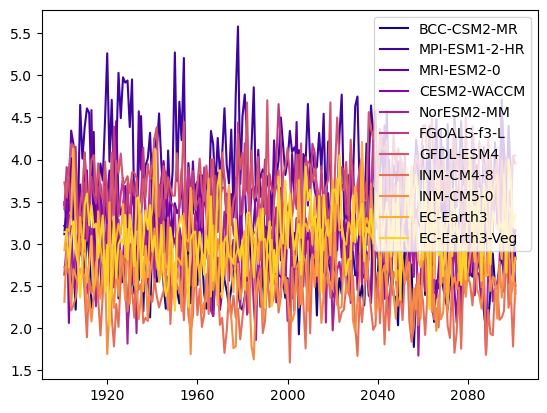

In [10]:
this_basin = 'RHONE'
rng = pd.date_range('1900-01-01', periods=2412, freq='M')

fig, ax = plt.subplots()
for i,this_GCM in enumerate(modelnames):
    this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
    this_precip.index=rng
    this_precip_dailyavg = this_precip / this_precip.index.days_in_month
    ## handy days_in_month utility
    this_precip_mmday = this_precip_dailyavg*1000 / (TotalBasinAreas.loc[this_basin].squeeze()*1e6)
    ## convert from m--> mm on top, km2-->m2 on bottom
    ax.plot(this_precip_mmday.resample('A').mean(), label=this_GCM, color=default_colors(i/len(modelnames)))
ax.legend(loc='best')

There are some pronounced offsets here.  Sloan previously plotted mm/day relative to 2000-2020...try that.  Remove 2000-2020 mean -- units are now correct mm/day following correction above (25 Jul 2024).



/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_86413/299432788.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),


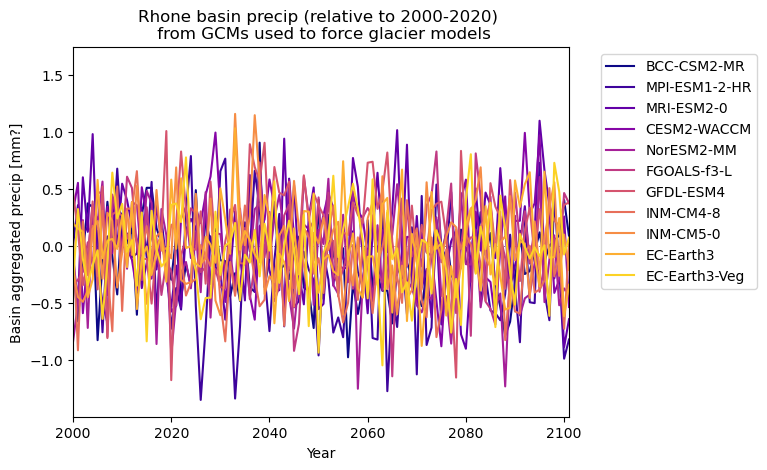

In [11]:
fig, ax = plt.subplots()
ax.axhline(0, color='k', ls=':', lw= 0.5)
for i,this_GCM in enumerate(modelnames):
    this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
    this_precip.index=rng
    
    this_precip_dailyavg = this_precip / this_precip.index.days_in_month
    ## handy days_in_month utility
    this_precip_mmday = this_precip_dailyavg*1000 / (TotalBasinAreas.loc[this_basin].squeeze()*1e6)

    hist_mean = this_precip_mmday['2000-01-31':'2020-12-31'].resample('A').mean().mean()
    ax.plot((this_precip_mmday.resample('A').mean()-hist_mean), label=this_GCM, color=default_colors(i/len(modelnames)))
ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=1)

ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),
      xlabel='Year',
      ylabel='Basin aggregated precip [mm?]',
      title='{} basin precip (relative to 2000-2020) \n from GCMs used to force glacier models'.format(str.capitalize(this_basin)));

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_86413/3324720435.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),


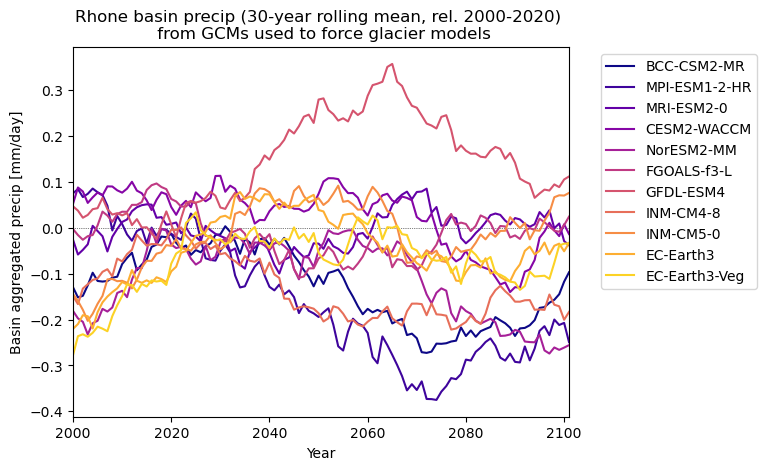

In [12]:
fig, ax = plt.subplots()
ax.axhline(0, color='k', ls=':', lw= 0.5)
for i,this_GCM in enumerate(modelnames):
    this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
    this_precip.index=rng
    
    this_precip_dailyavg = this_precip / this_precip.index.days_in_month
    ## handy days_in_month utility
    this_precip_mmday = this_precip_dailyavg*1000 / (TotalBasinAreas.loc[this_basin].squeeze()*1e6)

    hist_mean = this_precip_mmday['2000-01-31':'2020-12-31'].resample('A').mean().mean()
    ax.plot((this_precip_mmday.resample('A').mean()-hist_mean).rolling(window=30).mean(), label=this_GCM, color=default_colors(i/len(modelnames)))
ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=1)

ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),
      xlabel='Year',
      ylabel='Basin aggregated precip [mm/day]',
      title='{} basin precip (30-year rolling mean, rel. 2000-2020) \n from GCMs used to force glacier models'.format(str.capitalize(this_basin)));

Looks like all of these GCMs have increasing precip in the Rhone over the 21st century.  This is not representative of the CMIP archive that Sloan visualized!  Let's analyse some other basins.

## Spot check a few other basins

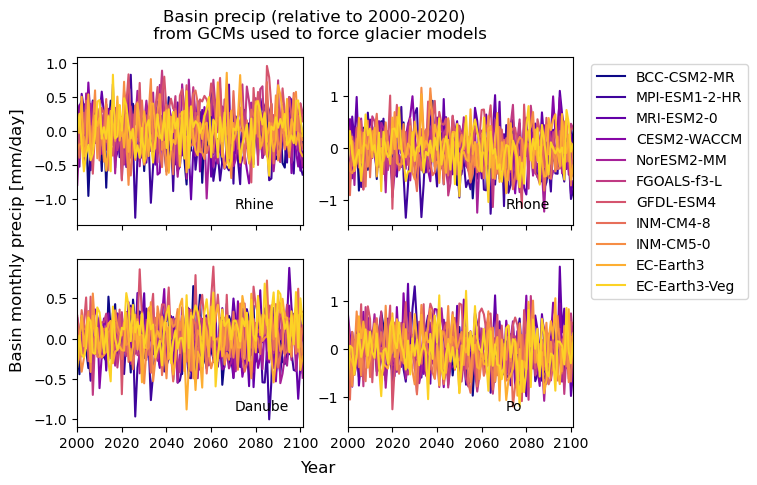

In [13]:
test_basins = ['RHINE', 'RHONE', 'DANUBE', 'PO']

fig, axs = plt.subplots(2,2, sharex=True)
for i, ax in enumerate(axs.ravel()):
    this_basin = test_basins[i]
    basin_label = ' '.join([s.capitalize() for s in this_basin.split(' ')])
    
    ax.axhline(0, color='k', ls=':', lw= 0.5)
    for i,this_GCM in enumerate(modelnames):
        this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
        this_precip.index=rng
        
        this_precip_dailyavg = this_precip / this_precip.index.days_in_month
        ## handy days_in_month utility
        this_precip_mmday = this_precip_dailyavg*1000 / (TotalBasinAreas.loc[this_basin].squeeze()*1e6)
        
        hist_mean = this_precip_mmday['2000-01-31':'2020-12-31'].resample('A').mean().mean()
        ax.plot((this_precip_mmday.resample('A').mean()-hist_mean), label=this_GCM, color=default_colors(i/len(modelnames)))

    ax.set(xlim=(datetime.datetime(1999,12,31),datetime.datetime(2100,12,31)))
    ax.text(0.7, 0.1, basin_label, transform=ax.transAxes)

axs[0,1].legend(bbox_to_anchor=(1.05, 1.0), ncol=1)
fig.suptitle('Basin precip (relative to 2000-2020) \n from GCMs used to force glacier models')
fig.supxlabel('Year')
fig.supylabel('Basin monthly precip [mm/day]');

Text(0.02, 0.5, 'Basin aggregated precip [mm/day]')

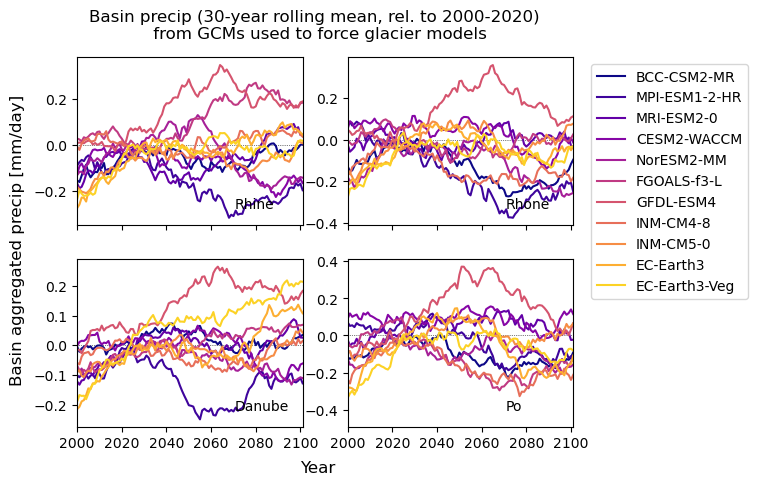

In [14]:
fig, axs = plt.subplots(2,2, sharex=True)
for i, ax in enumerate(axs.ravel()):
    this_basin = test_basins[i]
    basin_label = ' '.join([s.capitalize() for s in this_basin.split(' ')]) ## manage multi-word basin names
    
    ax.axhline(0, color='k', ls=':', lw= 0.5)
    for i,this_GCM in enumerate(modelnames):
        this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
        this_precip.index=rng
        
        this_precip_dailyavg = this_precip / this_precip.index.days_in_month
        ## handy days_in_month utility
        this_precip_mmday = this_precip_dailyavg*1000 / (TotalBasinAreas.loc[this_basin].squeeze()*1e6)
        
        hist_mean = this_precip_mmday['2000-01-31':'2020-12-31'].resample('A').mean().mean()
        ax.plot((this_precip_mmday.resample('A').mean()-hist_mean).rolling(window=30).mean(), 
                label=this_GCM, color=default_colors(i/len(modelnames)))

    ax.set(xlim=(datetime.datetime(1999,12,31),datetime.datetime(2100,12,31)))
    ax.text(0.7, 0.1, basin_label, transform=ax.transAxes)

axs[0,1].legend(bbox_to_anchor=(1.05, 1.0), ncol=1)
fig.suptitle('Basin precip (30-year rolling mean, rel. to 2000-2020) \n from GCMs used to force glacier models')
fig.supxlabel('Year')
fig.supylabel('Basin aggregated precip [mm/day]')